# Financial Mathematics
### Lab 4: Monte Carlo Methods in CRR Model

The purpose of this class is to implement Monte Carlo estimator for CRR Model.

In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from joblib import Parallel, delayed
from tabulate import tabulate

from crr_cython import evaluate_mc_cython

#### Market, Payoff, CCR Models

In [41]:
class Market():
    def __init__(self, T: int, up_factor: float, down_factor: float, interest_rate: float, initial_value: float):
        """
        Initialize the market parameters.
        T (int): Number of time steps
        up_factor (float): Up factor
        down_factor (float): Down factor
        interst_rate (float): interest rate
        initial_value (float): Initial stock price
        """
        self.T = T
        self.up_factor = up_factor
        self.down_factor = down_factor
        self.interest_rate = interest_rate
        self.initial_value = initial_value
        self.p_star = (1 + interest_rate - down_factor) / (up_factor - down_factor)
        
    def get_stock_price(self, k: int, n: int) -> float:
        return self.initial_value * (self.up_factor ** k) * (self.down_factor ** (n - k))
    
    def draw_binomial_tree(self) -> None:
        G = nx.DiGraph()
        for i in range(self.T + 1):
            for j in range(i + 1):
                G.add_node((i, j), pos=(i, j))
                if i < self.T:
                    G.add_edge((i, j), (i + 1, j + 1), weight=self.up_factor)
                    G.add_edge((i, j), (i + 1, j), weight=self.down_factor)
        
        pos = nx.get_node_attributes(G, 'pos')
        labels = {(i, j): f"{self.get_stock_price(j, i):.2f}" for i, j in G.nodes()}
        plt.figure(figsize=(12, 8))  
        nx.draw(G, pos=pos, with_labels=True, labels=labels, font_size=10, 
            node_color='gold', font_weight='bold', edge_color='lightgray', node_size=1500)
        plt.title("Stock Price Tree")
        plt.show()

In [42]:
class Payoff():
    def __call__(self, trajectory: list) -> float:
        raise NotImplementedError("Payoff must implement __call__ method")
    
class PayoffEuropean(Payoff):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, trajectory[-1] - self.strike)
    
    def set_strike(self, strike: float):
        self.strike = strike

class PayoffEuropeanCall(PayoffEuropean):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, trajectory[-1] - self.strike)
    
class PayoffEuropeanPut(PayoffEuropean):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, self.strike - trajectory[-1])    

class PayoffMaxTrajectoryValue(Payoff):
    def __call__(self, trajectory: list) -> float:
        return max(trajectory)

In [43]:

class CRRModel():
    """
    Cox-Ross-Rubinstein model for option pricing.
    
    This model uses a binomial tree to calculate the price of options.
    It recursively calculates the price at each node of the tree.
    """
    def __init__(self, market: Market, payoff: Payoff):
        """ 
        Initialize the Cox-Ross-Rubinstein model.
        market (Market): The market model
        payout (Payout): The payout structure
        """
        self.market = market
        self.payoff = payoff
        self.trajectory = [market.initial_value]
        
    def discount(self) -> float:
        if len(self.trajectory) == (self.market.T + 1):
            return self.payoff(self.trajectory)
        
        # up
        self.trajectory.append(self.trajectory[-1] * self.market.up_factor)
        price_up = self.discount()
        self.trajectory.pop()
        
        # down
        self.trajectory.append(self.trajectory[-1] * self.market.down_factor)
        price_down = self.discount()
        self.trajectory.pop()
        
        rate = 1 / (1 + self.market.interest_rate)
        p = self.market.p_star
        
        return rate * (p * price_up + (1 - p) * price_down)
    
    def evaluate_mc(self, M: int):
        assert M > 0, "Number of trajectories must be positive."
        
        payoffs = []
        
        for i in range(M):
           trajectory = self._sample_trajectory()
           value = self.payoff(trajectory)
           payoffs.append(value)
        
        cumsum_payoffs = np.cumsum(payoffs) / ((1 + self.market.interest_rate) ** self.market.T)
        res = cumsum_payoffs / (np.arange(1, M + 1))
        return res
    
    def _sample_trajectory(self):
        length = self.market.T + 1 
        trajectory = [self.market.initial_value]
        for i in range(length - 1):
            rand = np.random.uniform(0,1)
            if rand < self.market.p_star:
                trajectory.append(trajectory[-1] * self.market.up_factor)
            else:
                trajectory.append(trajectory[-1] * self.market.down_factor)
        return trajectory
    
    def evaluate_mc_numpy(self, M: int):
        assert M > 0, "Number of trajectories must be positive."
    
        rand_nums = np.random.uniform(0, 1, size=(M, self.market.T))
        up_moves = rand_nums < self.market.p_star
        
        factors = np.where(up_moves, self.market.up_factor, self.market.down_factor)
        trajectory_factors = np.cumprod(factors, axis=1)
        
        trajectory_factors = np.insert(trajectory_factors, 0, 1, axis=1)
        trajectories = self.market.initial_value * trajectory_factors
        payoffs = np.array([self.payoff(trajectory) for trajectory in trajectories])
        
        discount_factor = (1 + self.market.interest_rate) ** -self.market.T
        cumsum_payoffs = np.cumsum(payoffs) * discount_factor
        return cumsum_payoffs / np.arange(1, M + 1)
    
    def evaluate_mc_cython(self, M: int):
        return evaluate_mc_cython(
            M, 
            self.market.initial_value,
            self.market.up_factor,
            self.market.down_factor,
            self.market.p_star,
            self.market.interest_rate,
            self.market.T,
        )
        
    def _process_single_trajectory_optimized(self, _):
        random_vals = np.random.uniform(0, 1, size=self.market.T)
        up_moves = random_vals < self.market.p_star
        factors = np.where(up_moves, self.market.up_factor, self.market.down_factor)
        trajectory_factors = np.concatenate(([1], np.cumprod(factors)))
        trajectory = self.market.initial_value * trajectory_factors
        return self.payoff(trajectory)

    def evaluate_mc_parallel(self, M: int, n_jobs: int = -1, batch_size=None, verbose=0):
        payoffs = Parallel(n_jobs=n_jobs, batch_size=batch_size, verbose=verbose)(
            delayed(self._process_single_trajectory_optimized)(_) for _ in range(M)
        )
        payoffs = np.array(payoffs)
        discount_factor = (1 + self.market.interest_rate) ** -self.market.T
        cumsum_payoffs = np.cumsum(payoffs) * discount_factor
        return cumsum_payoffs / np.arange(1, M + 1)

#### Convergence

Example market: 
- T = 10
- up_factor = 1.3
- down_factor = 0.8
- interest_rate = 0.1
- initial_price = 100

In [50]:
market = Market(10, 1.3, 0.8, 0.1, 100)
payoff = PayoffMaxTrajectoryValue()
crr = CRRModel(market, payoff)
M = 1_000_000
res = crr.evaluate_mc(M)
discount_value = crr.discount()

In [45]:
def plot_convergence(k: int, K: int, res: np.ndarray, discount_value: float):
    plt.figure(figsize=(20,12))
    sns.lineplot(x = np.arange(k, K+1), y = res[k-1:K+1], color="blue", label = "Monte Carlo Estimator Value")
    plt.hlines(xmin = k, xmax = K, y = discount_value, color="crimson", label = "Exact Value")
    plt.legend()
    plt.title("Monte Carlo Estimator Convergence")
    plt.xlabel("Number of samples (M)")
    plt.ylabel("Monte Carlo Estimator Value")

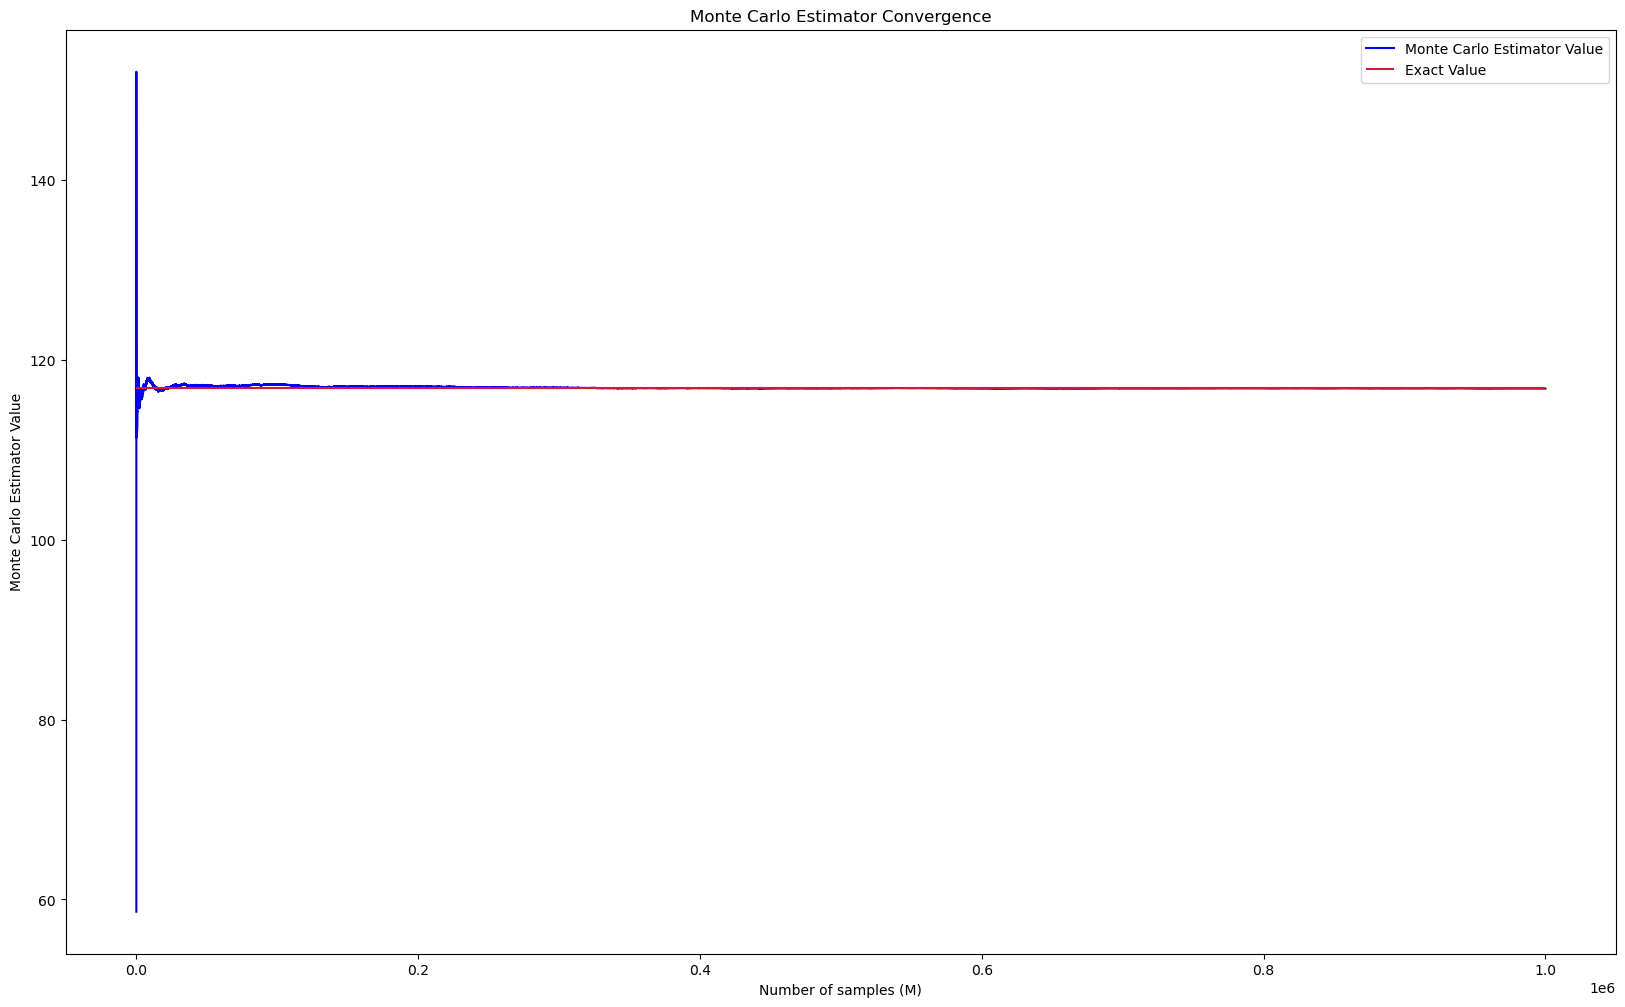

In [46]:
plot_convergence(1, M, res, discount_value)

To more accurately examine the behaviour for larger M values,let's start from 2000 samples.

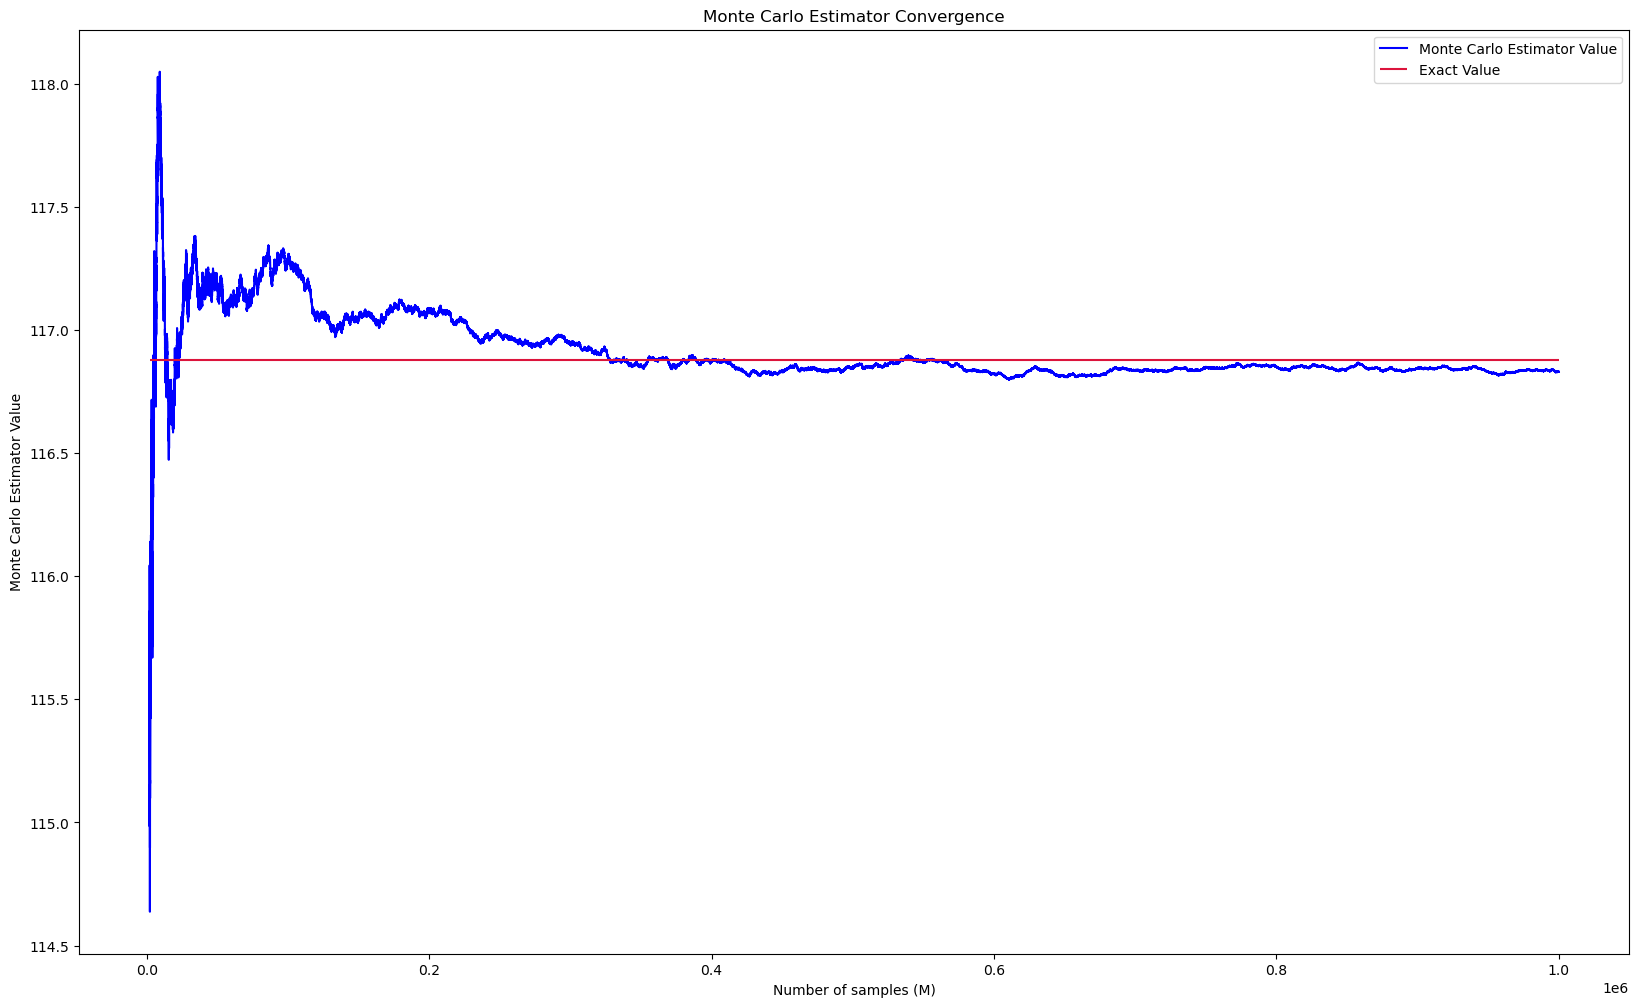

In [47]:
plot_convergence(2000, M, res, discount_value)

In [53]:
def plot_convergence_n_lines(k: int, M: int, crr: CRRModel, n: int):
    colors = sns.color_palette("Blues", n)
    
    plt.figure(figsize=(20,12))
    
    for i in range(n):
        discount_value = crr.discount()
        res = crr.evaluate_mc(M)
        sns.lineplot(x = np.arange(k, M+1), y = res[k-1:M+1], color=colors[np.random.randint(0, len(colors))], label = "Monte Carlo Estimator Value")
    plt.hlines(xmin = k, xmax = M, y = discount_value, color="crimson", label = "Exact Value")
    plt.legend()
    plt.title(f"Monte Carlo Estimator Convergence (from {k} to {M} samples)")
    plt.xlabel("Number of samples (M)")
    plt.ylabel("Monte Carlo Estimator Value")

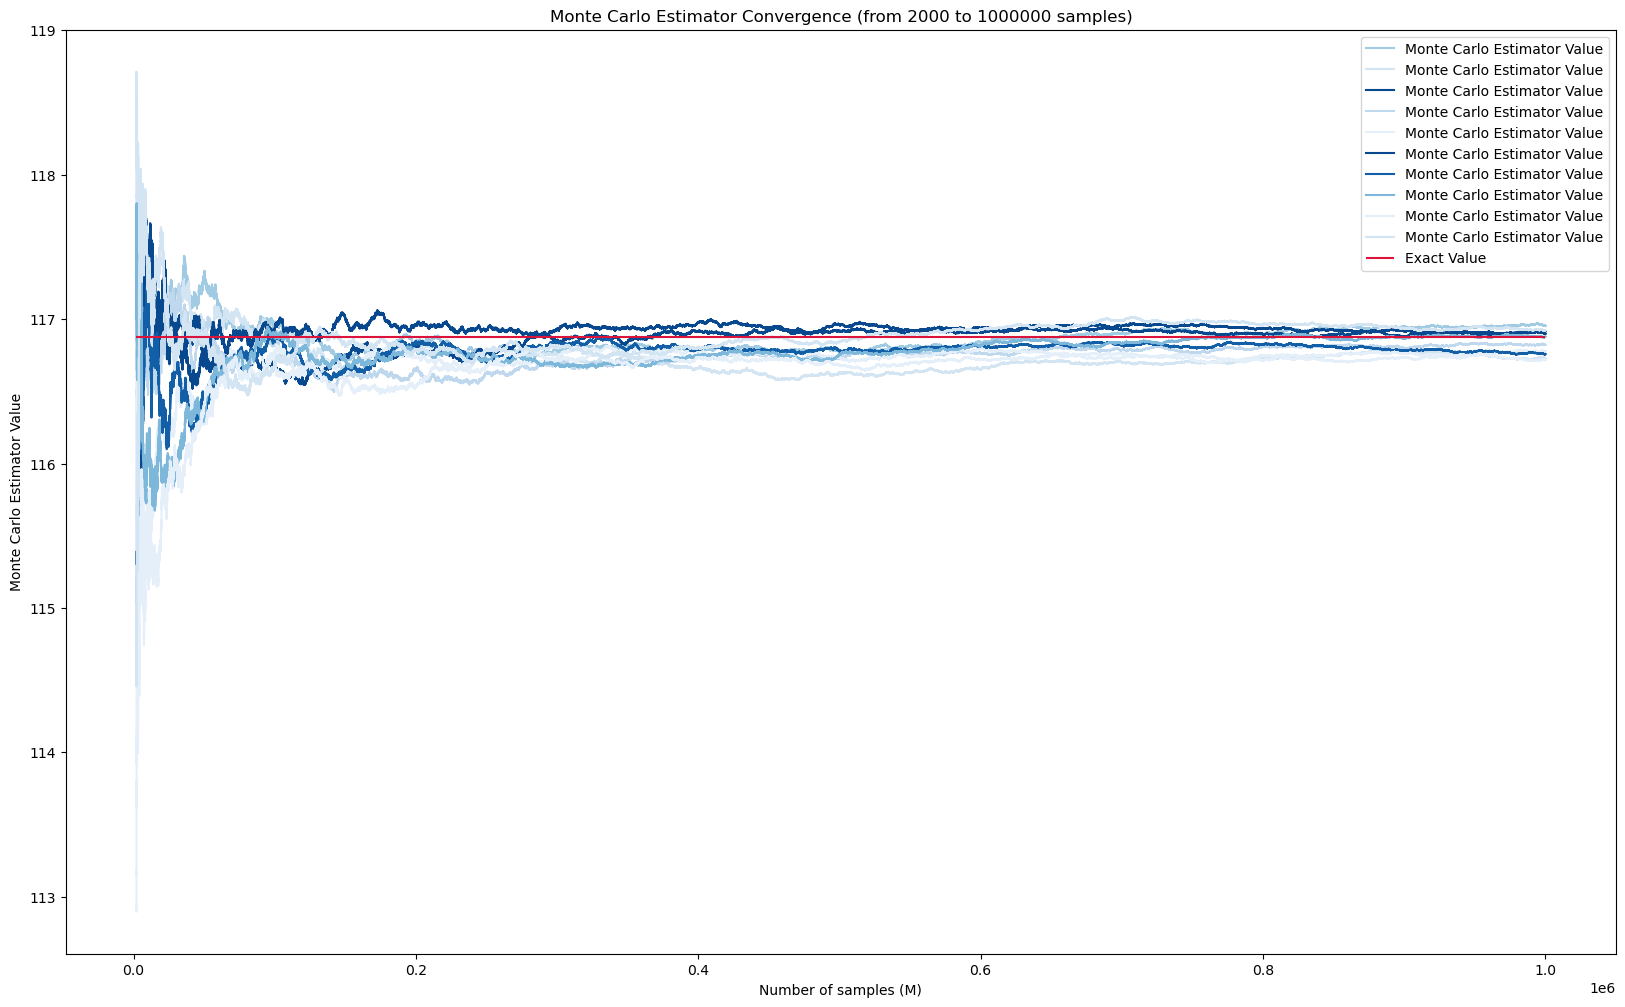

In [54]:
plot_convergence_n_lines(2_000, 1_000_000, crr, 10)

#### High T values

Let's find the highest T possible, for which the accurate algorithm is executed in acceptable time.


Acceptable time: 10 min

In [108]:
T = 30

market = Market(T, 1.3, 0.8, 0.1, 100)
crr = CRRModel(market, payoff)

In [109]:
%timeit -n 1 -r 3 crr.discount()

9min 24s ± 2.7 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [111]:
T = 31

market2 = Market(T, 1.3, 0.8, 0.1, 100)
crr2 = CRRModel(market, payoff)

In [112]:
%timeit -n 1 -r 3 crr2.discount()

18min 56s ± 1.74 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


**T = 30: 9 min 24 sec**  
T = 31: 18 min 56 sec

For different Ts, the real value V_exact ist different, therefore separate plots are drawn.

In [ ]:
def compare_convergence(T_list: list,
                        up_factor: float,
                        down_factor: float, 
                        interest_rate: float,
                        initial_value: float,
                        payoff: Payoff,
                        M: int,
                        k: int,
                        crr_discount_values: list = None):
    fig, axes = plt.subplots(len(T_list), 1, figsize=(20, 10 * len(T_list)))
    
    for i, T in enumerate(T_list):
        market = Market(T, up_factor, down_factor, interest_rate, initial_value)
        crr = CRRModel(market, payoff)
        if crr_discount_values is None:
            discount_value = crr.discount()
        else:
            discount_value = crr_discount_values[i]
        mc_values = crr.evaluate_mc(M)
        sns.lineplot(x = np.arange(k, M+1), y = mc_values[k-1:M+1], color="blue", label = "Monte Carlo Estimator Value", ax = axes[i]);
        axes[i].hlines(xmin = k, xmax = M, y = discount_value, color="crimson", label = "Exact Value")
        axes[i].set_title(f"Monte Carlo Estimator converence for T = {T}")
        axes[i].set_xlabel("Number of samples (M)")
        axes[i].set_ylabel("Monte Carlo Estimator Value")
 
    fig.show();

/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_42090/485428516.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


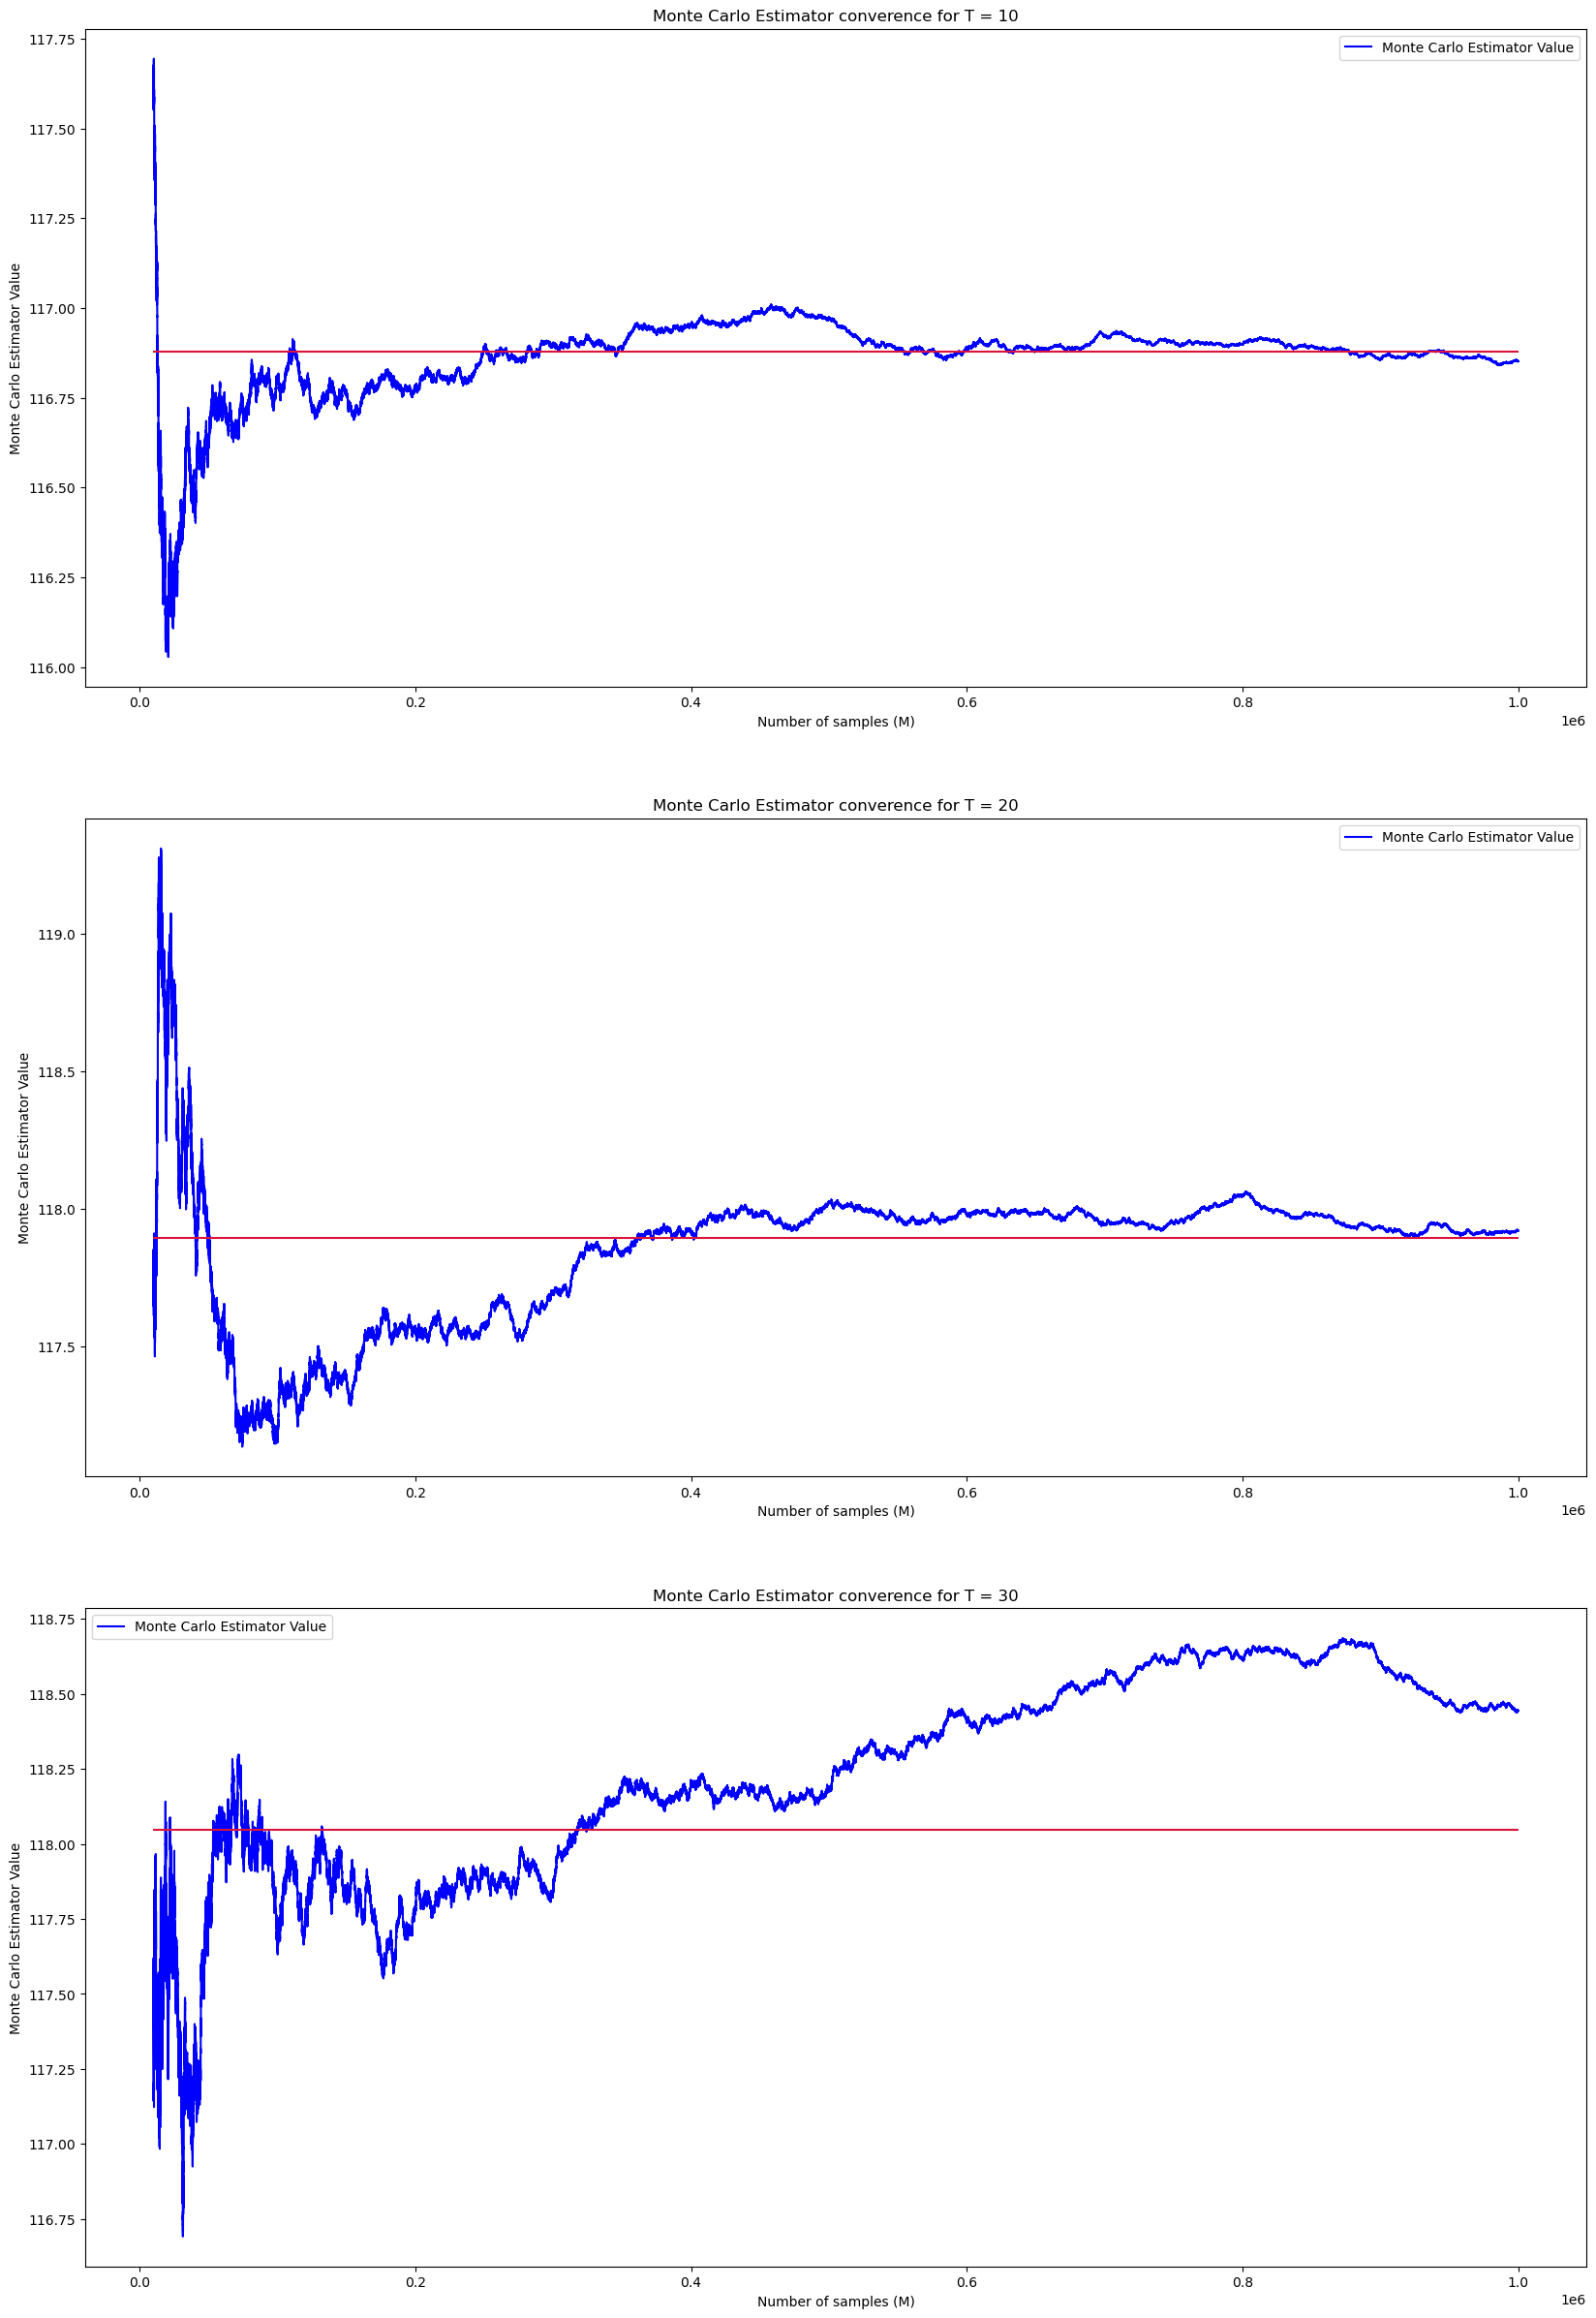

In [113]:
compare_convergence([10, 20, 30], 1.3, 0.8, 0.1, 100, PayoffMaxTrajectoryValue(), 1_000_000, 10_000)

It can be concluded that the lower the T, the quicker the convergence. Let's verify this hypothesis.

In [94]:
def compare_convergence_variances(T_list: list,
                        up_factor: float,
                        down_factor: float, 
                        interest_rate: float,
                        initial_value: float,
                        payoff: Payoff,
                        M: int,
                        k: int):
    variances = []
    for i, T in enumerate(T_list):
        market = Market(T, up_factor, down_factor, interest_rate, initial_value)
        crr = CRRModel(market, payoff)
        mc_values = crr.evaluate_mc(M)
        mc_values_selected = mc_values[k-1:M+1]
        variance = np.var(mc_values_selected)
        variances.append(variance)
    
    plt.figure(figsize=(12,8))
    sns.barplot(x = T_list, y = variances)
    plt.title(f"Variance of Monte Carlo Estimator for last {M - k} samples")

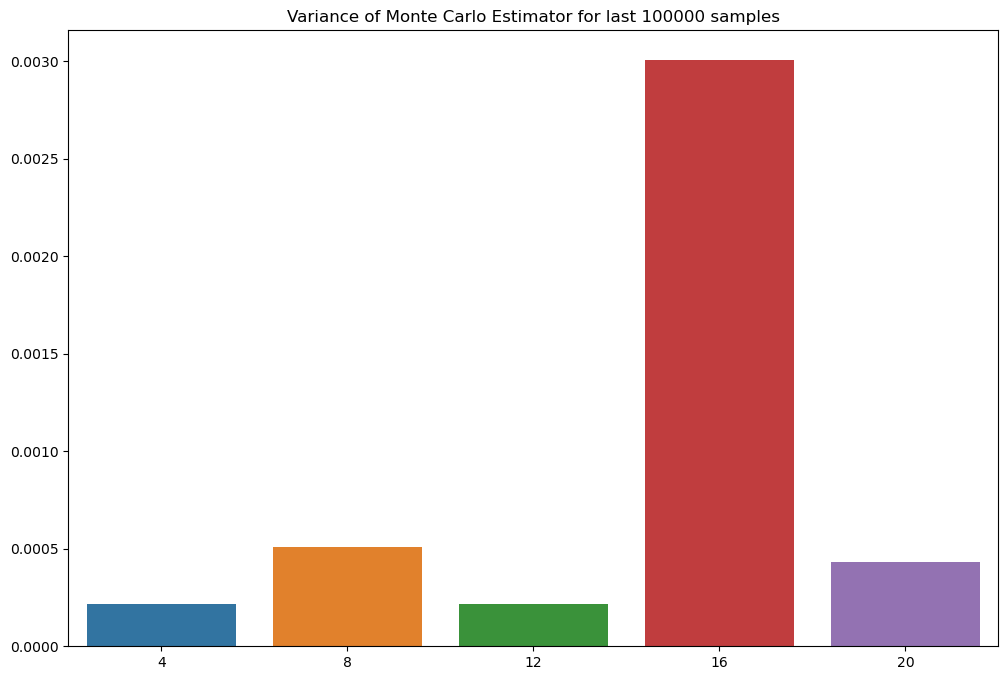

In [95]:
compare_convergence_variances([4, 8, 12, 16, 20],
                              1.3,
                              0.8,
                              0.1,
                              100,
                              PayoffMaxTrajectoryValue(),
                              500_000,
                              400_000)
                              

One test may not be enough, as the result highly depends on random seed.

In [ ]:
def compare_convergence_variances_violinplots(T_list: list,
                        up_factor: float,
                        down_factor: float, 
                        interest_rate: float,
                        initial_value: float,
                        payoff: Payoff,
                        M: int,
                        k: int, 
                        n_tests = 5):
    all_variances = []
    T_values = []
    mean_variances = []
    
    for T in T_list:
        market = Market(T, up_factor, down_factor, interest_rate, initial_value)
        crr = CRRModel(market, payoff)
        
        variances = []
        for _ in range(n_tests):
            mc_values = crr.evaluate_mc_numpy(M)
            mc_values_selected = mc_values[k-1:M+1]
            variance = np.var(mc_values_selected)
            variances.append(variance)
        
        all_variances.extend(variances)
        T_values.extend([T] * n_tests)
        mean_variances.append(np.mean(variances))
    
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x=T_values, y=all_variances)
    plt.title("Variance of Monte Carlo Estimator")
    plt.xlabel("T (Number of Time Steps)")
    plt.ylabel("Variance")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=T_list, y=mean_variances, marker='o', color='blue')
    plt.title("Mean Variance of Monte Carlo Estimator")
    plt.xlabel("T (Number of Time Steps)")
    plt.ylabel("Mean Variance")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


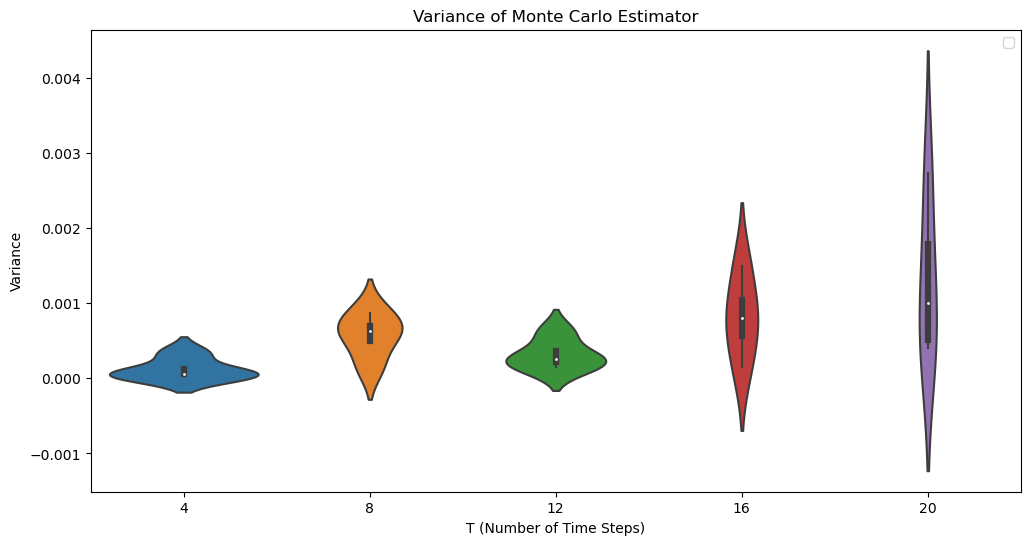

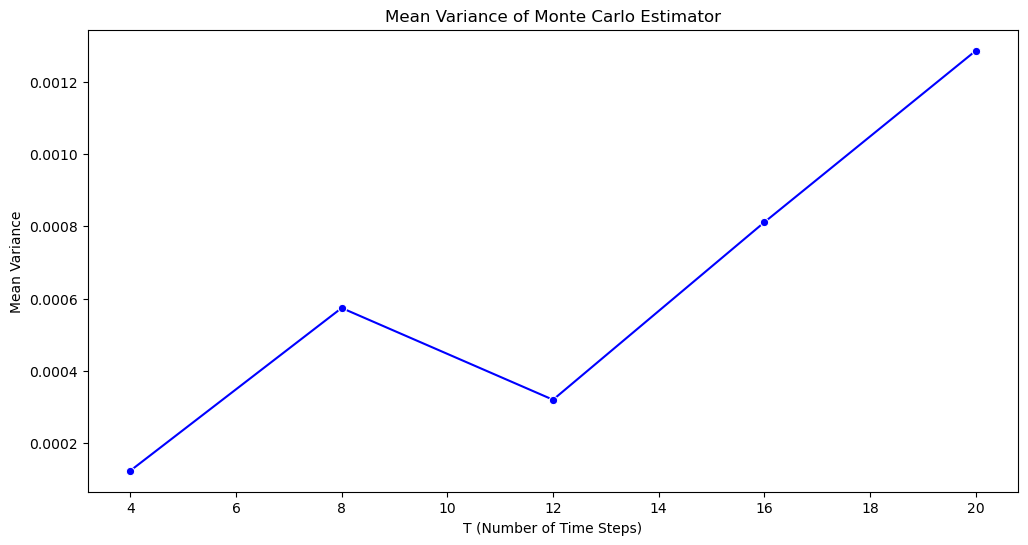

In [98]:
compare_convergence_variances_violinplots([4, 8, 12, 16, 20],
                              1.3,
                              0.8,
                              0.1,
                              100,
                              PayoffMaxTrajectoryValue(),
                              500_000,
                              400_000, 
                              4)

In general, the trend is present and therefore the hypothesis holds. 

#### T values too big for standard method

Highest T value that meets the acceptable calculation time (10 mins) is T = 30. Now let's find the largest possible T for which the Monte Carlo Algorithm converges stably in less than 1M iterations.


In [78]:
def compare_T_vals_mc(T_list: list,
                        up_factor: float,
                        down_factor: float, 
                        interest_rate: float,
                        initial_value: float,
                        payoff: Payoff,
                        M: int,
                        k: int):
    res = {}
    
    for T in T_list:
        crr = CRRModel(Market(T, up_factor, down_factor, interest_rate, initial_value), payoff)
        res[T] = crr.evaluate_mc_numpy(M)[k-1:M+1]
        
    plt.figure(figsize=(20, 10))
    for T, values in res.items():
        sns.lineplot(x = np.arange(k, M+1), y = values, label = f"T = {T}")
    plt.title(f"Monte Carlo Estimator Convergence for different T values, {k} to {M} samples")
    plt.xlabel("Number of samples (M)")
    plt.ylabel("Monte Carlo Estimator Value")   
    plt.legend()

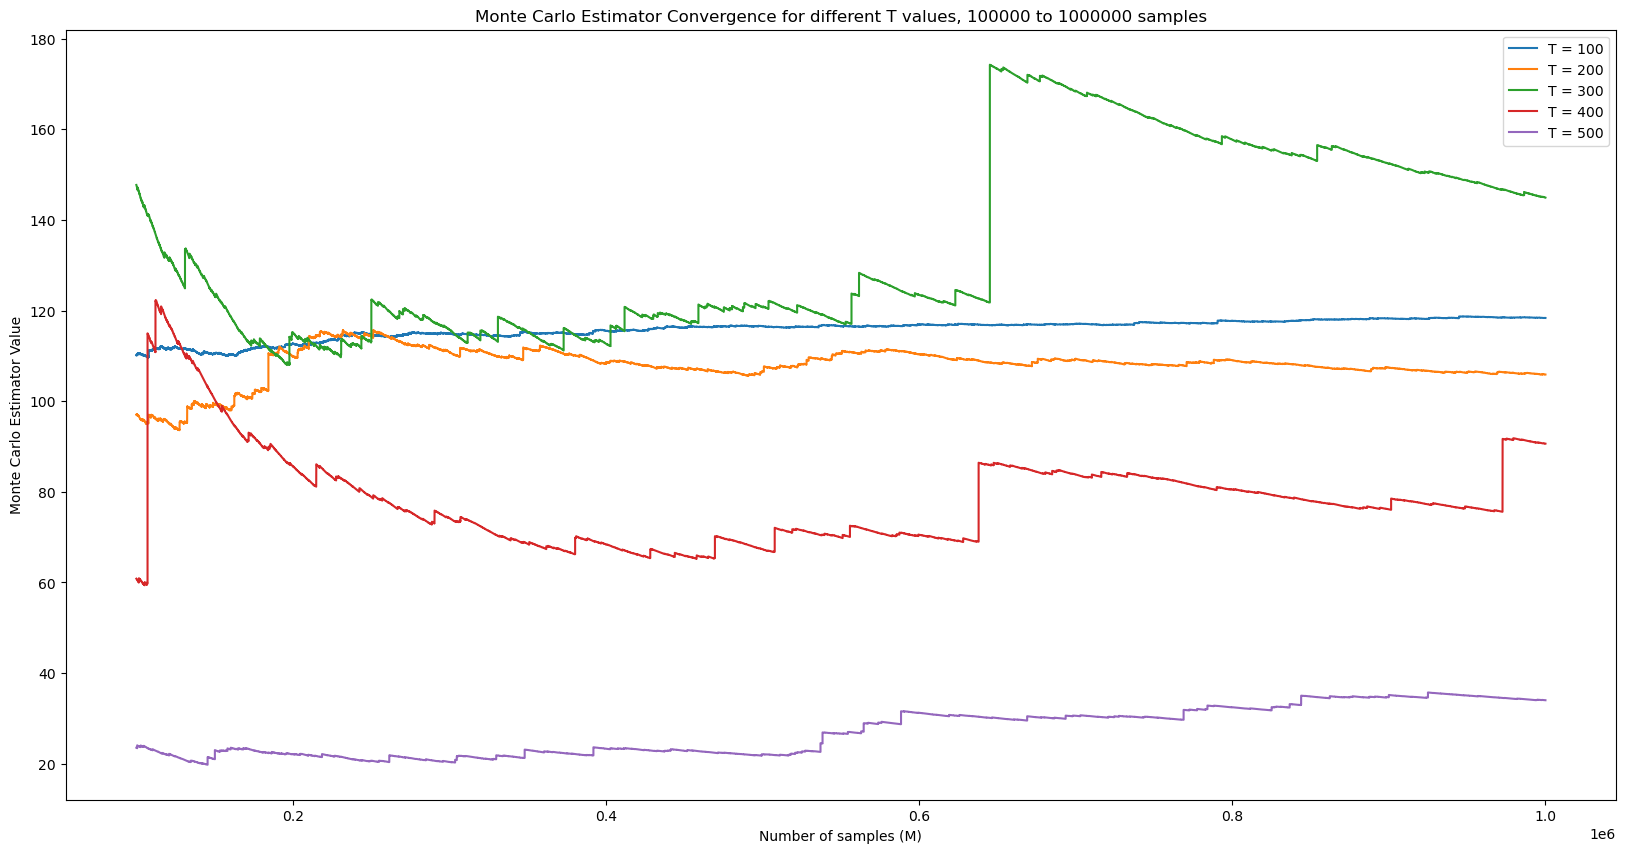

In [83]:
compare_T_vals_mc([100, 200, 300, 400, 500],
                  1.3,
                  0.8,
                  0.1,
                  100,
                  PayoffMaxTrajectoryValue(),
                  1_000_000,
                  100_000)

Now, let's examine T values from [150, 300].

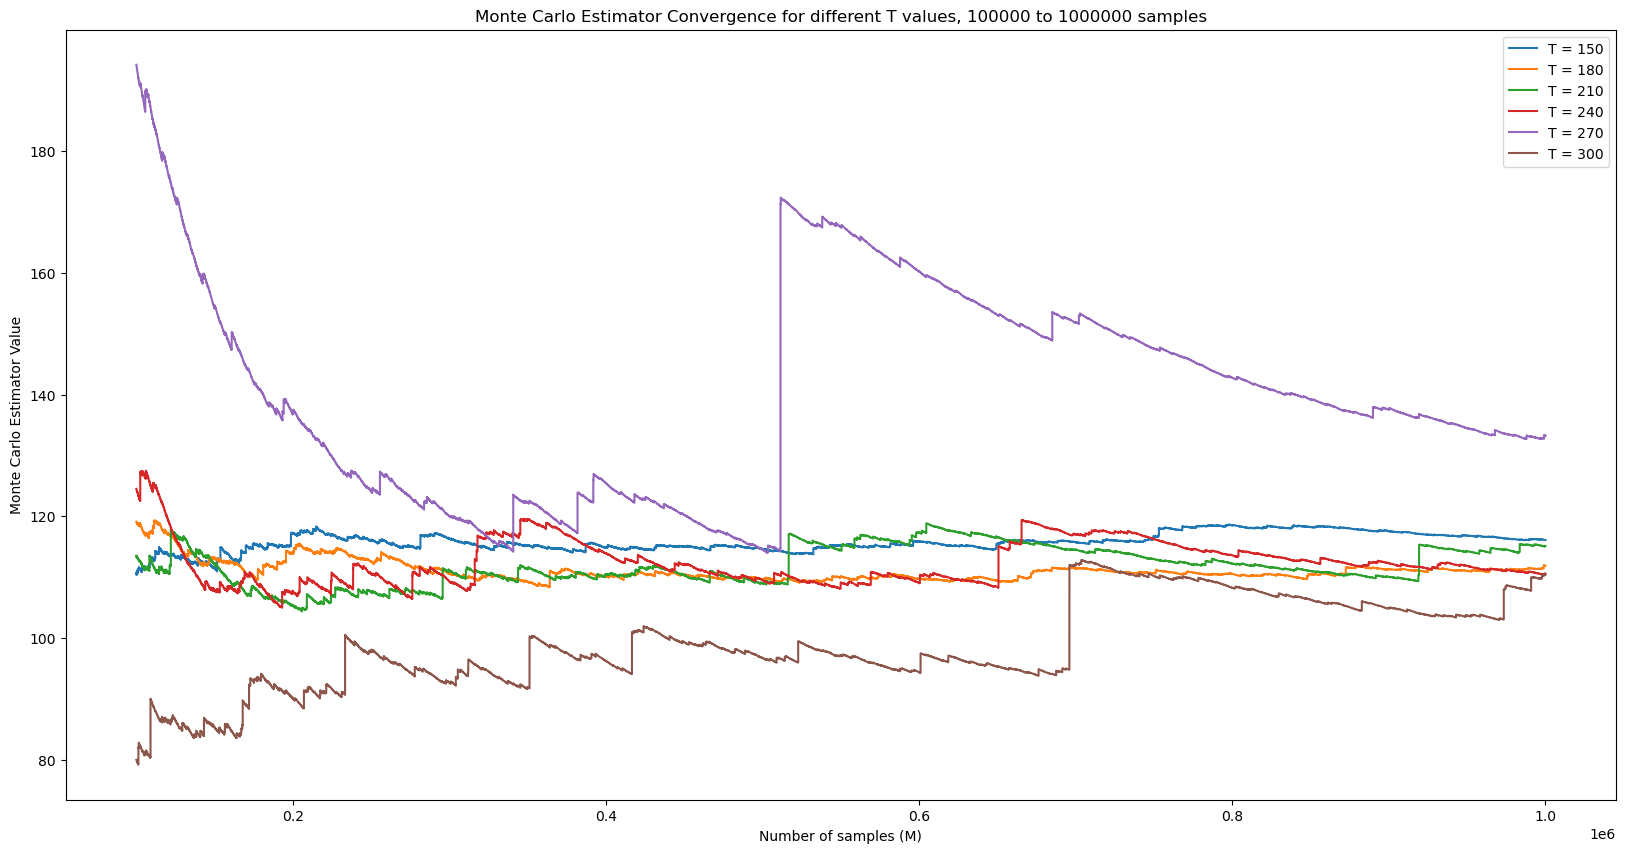

In [88]:
compare_T_vals_mc([150, 180, 210, 240, 270, 300],
                  1.3,
                  0.8,
                  0.1,
                  100,
                  PayoffMaxTrajectoryValue(),
                  1_000_000,
                  100_000)

Let's examine [170, 200].

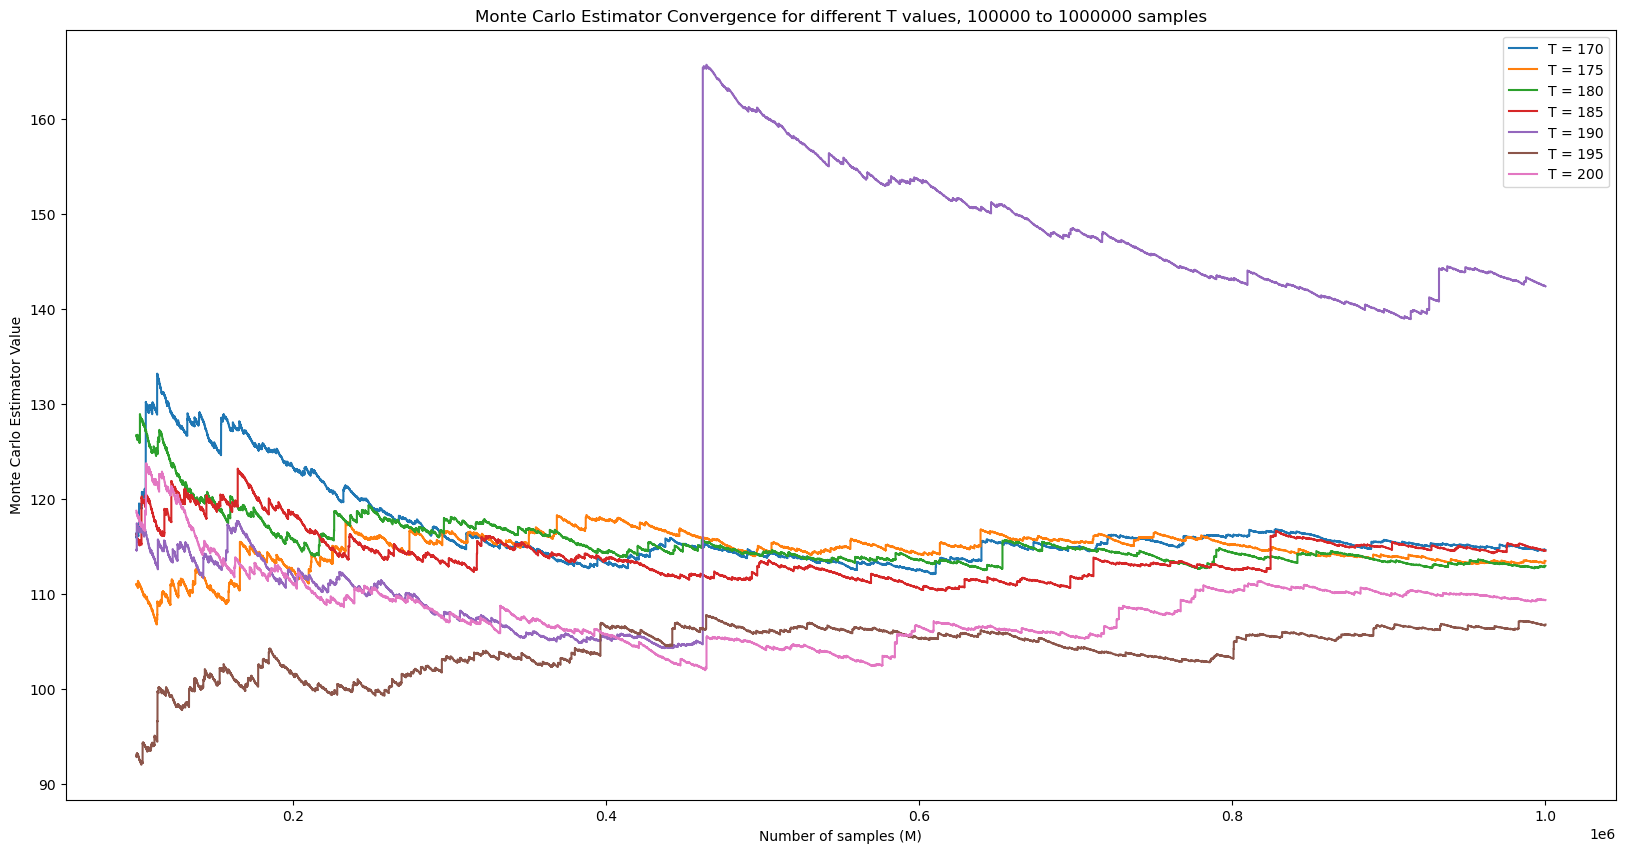

In [103]:
compare_T_vals_mc([170, 175, 180, 185, 190, 195, 200],
                  1.3,
                  0.8,
                  0.1,
                  100,
                  PayoffMaxTrajectoryValue(),
                  1_000_000,
                  100_000)

Finally, let's examine [170, 180].

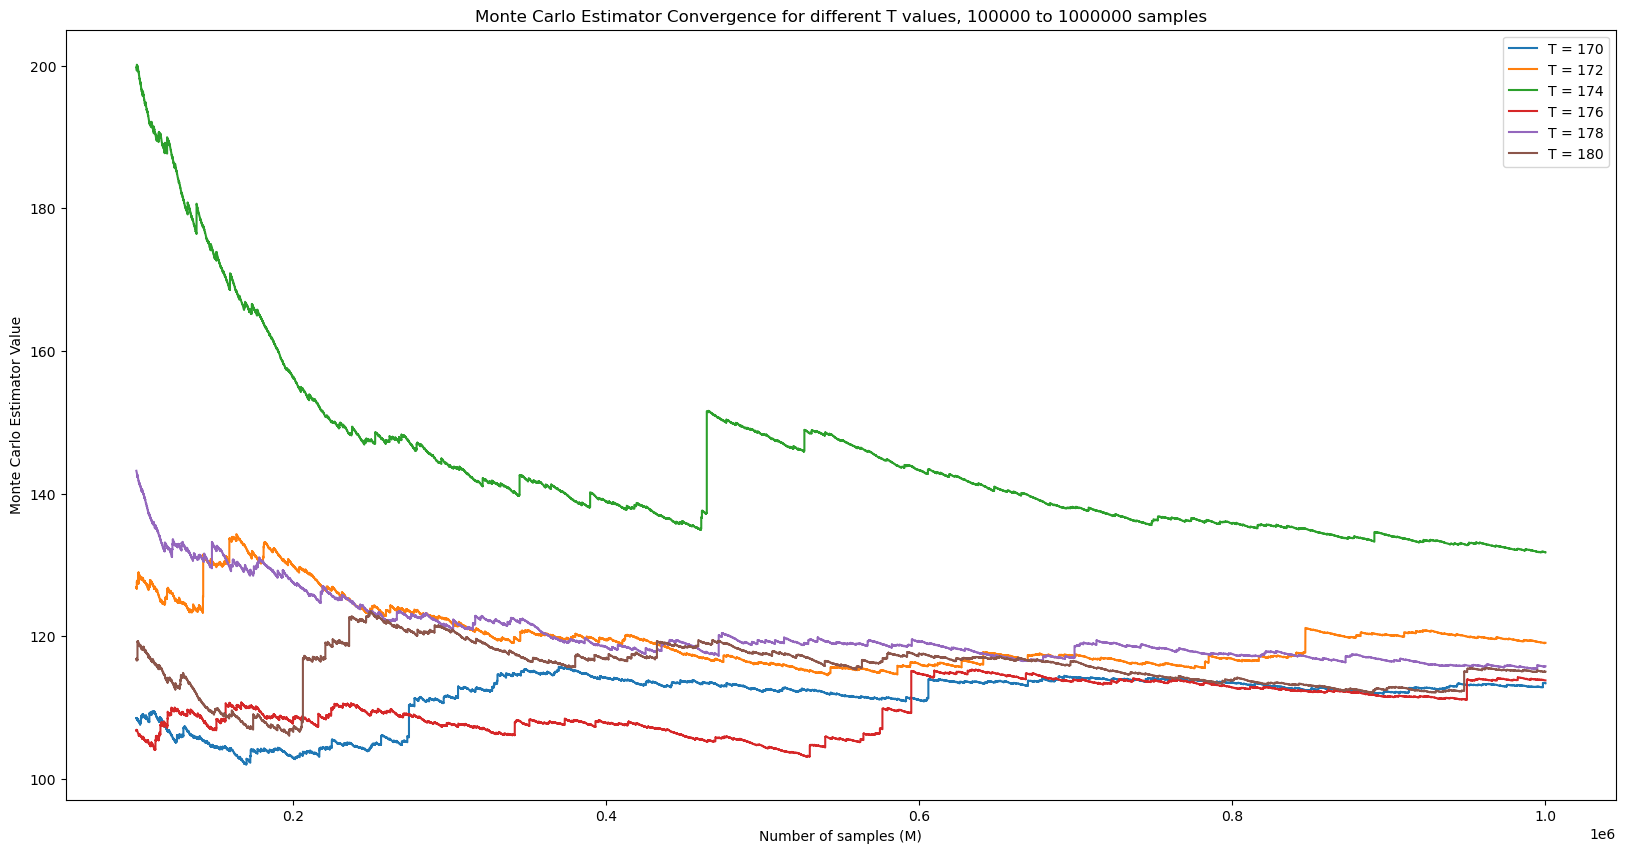

In [111]:
compare_T_vals_mc([170, 172, 174, 176, 178, 180],
                  1.3,
                  0.8,
                  0.1,
                  100,
                  PayoffMaxTrajectoryValue(),
                  1_000_000,
                  100_000)

The highest T value for which Monte Carlo methods converge stably is 170.

*This estimation may be biased because of random choice of paths.* If this experiment was of high importance, it would be useful to calculate mean variance in at the end of the plot (like in the previous paragraph).

#### Execution times comparison

3 implementations of `evaluate_mc` are examined:
- Python
- NumPy
- Cython

In [ ]:
def measure_performance(n=10, M = 100_000):
    market = Market(T=5, up_factor=1.3, down_factor=0.8, interest_rate=0.1, initial_value=100)
    payoff = PayoffMaxTrajectoryValue()
    model = CRRModel(market, payoff)
    
    python_times = [timeit.timeit(lambda: model.evaluate_mc(M), number=1) for _ in range(n)]
    numpy_times = [timeit.timeit(lambda: model.evaluate_mc_numpy(M), number=1) for _ in range(n)]
    cython_times = [timeit.timeit(lambda: model.evaluate_mc_cython(M), number=1) for _ in range(n)]
    # parallel_times = [timeit.timeit(lambda: model.evaluate_mc_parallel(M), number=1) for _ in range(n)]
    
    print("--- Performance Comparison ---")
    print(f"Number of tests: {n}")
    data = [
        ["Original Python", f"{np.mean(python_times):.4f}", f"{np.std(python_times):.4f}"],
        ["NumPy vectorized", f"{np.mean(numpy_times):.4f}", f"{np.std(numpy_times):.4f}"],
        ["Cython", f"{np.mean(cython_times):.4f}", f"{np.std(cython_times):.6f}"]
    ]
    
    headers = ["Method", "Mean Time (s)", "Standard Deviation (s)"]
    print(tabulate(data, headers=headers, tablefmt="grid"))
    # print(f"Parallel (4 cores): {np.mean(parallel_times):.4f} seconds (mean over {n} runs)")
    
    methods = ['Python'] * n + ['NumPy'] * n + ['Cython'] * n
    times = python_times + numpy_times + cython_times 
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(x=methods, y=times, palette="muted")
    plt.yscale('log')
    plt.title('Performance Comparison of Monte Carlo Implementations')
    plt.ylabel('Execution Time (seconds, log scale)')
    plt.xlabel('Method')
    plt.show()
    
    print("--- Analysis ---")
    print(f"NumPy is on average {np.mean(python_times) / np.mean(numpy_times):.2f} times faster than Python")
    print(f"Cython is on average {np.mean(numpy_times) / np.mean(cython_times):.2f} times faster than NumPy")
    print(f"Cython is on average {np.mean(python_times) / np.mean(cython_times):.2f} times faster than Python")

--- Performance Comparison ---
Number of tests: 100
+------------------+-----------------+--------------------------+
| Method           |   Mean Time (s) |   Standard Deviation (s) |
+==================+=================+==========================+
| Original Python  |          0.4691 |                 0.027    |
+------------------+-----------------+--------------------------+
| NumPy vectorized |          0.0547 |                 0.0013   |
+------------------+-----------------+--------------------------+
| Cython           |          0.0027 |                 0.000353 |
+------------------+-----------------+--------------------------+


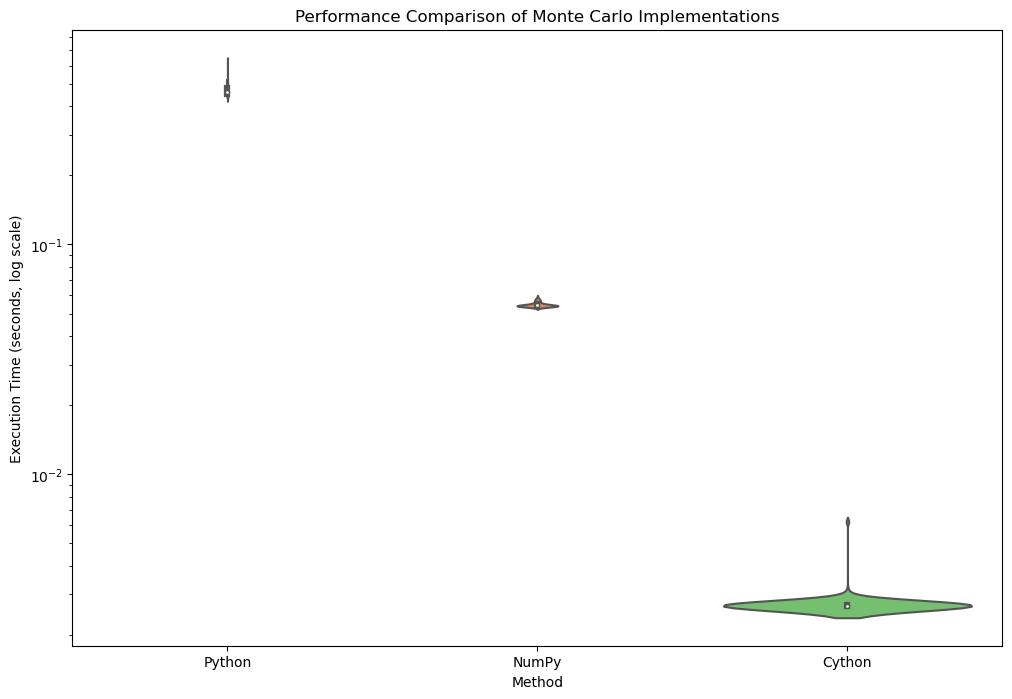

--- Analysis ---
NumPy is on average 8.58 times faster than Python
Cython is on average 20.10 times faster than NumPy
Cython is on average 172.39 times faster than Python


In [101]:
measure_performance(100)